In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize
from scipy.special import expit

In [42]:
data = pd \
    .read_csv('data/neural_network.txt', names=['x1', 'x2', 'y']) \
    .sample(frac=1)
data.reset_index(inplace=True, drop=True)

for column in data.columns:
    if column == 'y':
        continue
    data[column] = (data[column] - data[column].mean()) / data[column].std()
    
print(data.describe())
data.head()

                 x1            x2           y
count  1.180000e+02  1.180000e+02  118.000000
mean   2.822601e-17  3.481208e-17    1.508475
std    1.000000e+00  1.000000e+00    0.502060
min   -1.781621e+00 -1.833294e+00    1.000000
25%   -8.595503e-01 -8.417365e-01    1.000000
50%   -1.230541e-01  5.840087e-02    2.000000
75%    8.540982e-01  8.917119e-01    2.000000
max    2.045934e+00  1.781262e+00    2.000000


,x1,x2,y
0,-0.389807,-0.876898,1
1,-1.572844,-0.511221,2
2,0.688832,1.232780,2
3,-0.239038,-0.708122,1
4,0.781613,0.937422,1


In [43]:
unique = pd.unique(data['y'])
counter = 0
output_to_modeled = dict()
modeled_to_real = dict()
for unique_output in unique:
    output_to_modeled[unique_output] = counter
    modeled_to_real[counter] = unique_output
    data.loc[data['y'] == unique_output, 'y'] = counter
    counter = counter + 1

output_layer_size=counter

del counter
del unique

print('output_layer_size', output_layer_size)
print('output_to_modeled', output_to_modeled)
print('modeled_to_real', modeled_to_real)

data.head()

output_layer_size 2
output_to_modeled {1: 0, 2: 1}
modeled_to_real {0: 1, 1: 2}


,x1,x2,y
0,-0.389807,-0.876898,0
1,-1.572844,-0.511221,1
2,0.688832,1.232780,1
3,-0.239038,-0.708122,0
4,0.781613,0.937422,0


In [23]:
def draw_train_set(data):
    ax = data[data['y'] == 0].plot.scatter(x='x1', y='x2', c='red')
    data[data['y'] == 1].plot.scatter(x='x1', y='x2', c='blue', ax=ax)

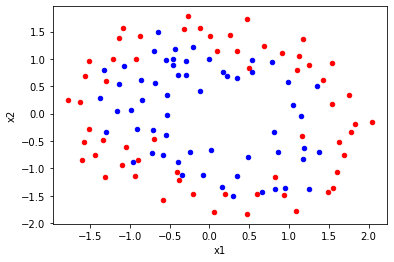

In [24]:
draw_train_set(data)

In [198]:
def extract(data, start, end):
    m = data.shape[0]
    view = data[start:(end - 1)]
    
    dropped_view = view
    if 'y' in data.columns:
        dropped_view = dropped_view.drop('y', axis=1)
    if 'y^' in data.columns:
        dropped_view = dropped_view.drop('y^', axis=1)
    X = dropped_view.to_numpy()
    y = None
    if 'y' in data.columns:
        y = view['y'].to_numpy().reshape(view.shape[0], 1)
    return X, y
    
def cost_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size):
    # Note: np.multiply performs element-wise multiplication instead of matrix multiplication
    # Note: np.matmul performs matrix multiplication
    # Note: expit is the sigmoid function
    
    m = X.shape[0]
    n = X.shape[1]
    
    Thetas = []
    
    offset = 0
    last_layer_size = n
    next_offset = 0
    for hidden_layer_size in hidden_layer_sizes:
        offset = next_offset
        next_offset = offset + hidden_layer_size * (last_layer_size + 1)
        Thetas.append(theta[offset:next_offset].reshape(hidden_layer_size, last_layer_size + 1))
        last_layer_size = hidden_layer_size
    offset = next_offset
    next_offset = offset + output_layer_size * (last_layer_size + 1)
    Thetas.append(theta[offset:next_offset].reshape(output_layer_size, last_layer_size + 1))
        
    Y = np.zeros((m, output_layer_size))
    for i in range(0, m):
        Y[i, y[i,0]] = 1
        
    A = [np.concatenate((
        np.ones((m, 1)),
        X
    ), axis=1)]
    for i in range(1, len(hidden_layer_sizes) + 2):
        z = np.matmul(A[i - 1], Thetas[i - 1].T)
        a = np.concatenate((
                np.ones((m,1)),
                expit(z)
        ), axis=1)
        A.append(a)
    
    H = A[-1][:, 1:]
    
    J = 0
    for i in range(0, output_layer_size):
        yit = Y[:, i]
        hi = H[:, i]
        J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
        
    reg = 0
    for Theta in Thetas:
        view = Theta[:, 1:]
        reg = reg + np.sum(np.multiply(view, view))
    
    J = (J + ((lamb / 2) * reg)) / m
        
    return J

def gradient_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size):
    m = X.shape[0]
    n = X.shape[1]
    
    Thetas = []
    
    offset = 0
    last_layer_size = n
    next_offset = 0
    for hidden_layer_size in hidden_layer_sizes:
        offset = next_offset
        next_offset = offset + hidden_layer_size * (last_layer_size + 1)
        Thetas.append(theta[offset:next_offset].reshape(hidden_layer_size, last_layer_size + 1))
        last_layer_size = hidden_layer_size
    offset = next_offset
    next_offset = offset + output_layer_size * (last_layer_size + 1)
    Thetas.append(theta[offset:next_offset].reshape(output_layer_size, last_layer_size + 1))
        
    Y = np.zeros((m, output_layer_size))
    for i in range(0, m):
        Y[i, y[i,0]] = 1
        
    A = [np.concatenate((
        np.ones((m, 1)),
        X
    ), axis=1)]
    for i in range(1, len(hidden_layer_sizes) + 2):
        z = np.matmul(A[i - 1], Thetas[i - 1].T)
        a = np.concatenate((
                np.ones((m,1)),
                expit(z)
        ), axis=1)
        A.append(a)
    
    H = A[-1][:, 1:]
    
    D = [None] * (len(hidden_layer_sizes) + 2)
    D[len(hidden_layer_sizes) + 1] = H - Y
    for i in range(len(hidden_layer_sizes), 0, -1):
        D[i] = np.matmul(D[i + 1], Thetas[i])
        D[i] = np.multiply(np.multiply(D[i], A[i]), 1 - A[i])
        D[i] = D[i][:, 1:]
    
    Delta = []
    for i in range(0, len(hidden_layer_sizes) + 1):
        Delta.append(np.matmul(D[i + 1].T, A[i]))
        
    Theta_Grads = []
    for i in range(0, len(hidden_layer_sizes) + 1):
        t = np.concatenate((
            np.zeros((Thetas[i].shape[0], 1)),
            Thetas[i][:, 1:]
        ), axis=1)
        Theta_Grads.append((Delta[i] + lamb * t) / m)
    
    to_concatenate = []
    for i in range(0, len(hidden_layer_sizes) + 1):
        to_concatenate.append(Theta_Grads[i].reshape( Theta_Grads[i].shape[0] * Theta_Grads[i].shape[1] ))
    
    return np.concatenate(to_concatenate)

def solve(X, y, lamb, hidden_layer_sizes, output_layer_size):
    n = 0
    last_layer_size = X.shape[1]
    for hidden_layer_size in hidden_layer_sizes:
        n = n + hidden_layer_size * (last_layer_size + 1)
        last_layer_size = hidden_layer_size
    n = n + output_layer_size * (last_layer_size + 1)
    
    result = optimize.minimize(
        lambda theta: cost_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size),
        jac=lambda theta: gradient_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size),
        x0=np.random.rand(n),
        method='BFGS')
    return result.x.reshape(n, 1)

def predict(X, theta, hidden_layer_sizes, output_layer_size):
    m = X.shape[0]
    n = X.shape[1]
    
    Thetas = []
    
    offset = 0
    last_layer_size = n
    next_offset = 0
    for hidden_layer_size in hidden_layer_sizes:
        offset = next_offset
        next_offset = offset + hidden_layer_size * (last_layer_size + 1)
        Thetas.append(theta[offset:next_offset].reshape(hidden_layer_size, last_layer_size + 1))
        last_layer_size = hidden_layer_size
    offset = next_offset
    next_offset = offset + output_layer_size * (last_layer_size + 1)
    Thetas.append(theta[offset:next_offset].reshape(output_layer_size, last_layer_size + 1))
        
    A = [np.concatenate((
        np.ones((m, 1)),
        X
    ), axis=1)]
    for i in range(1, len(hidden_layer_sizes) + 2):
        z = np.matmul(A[i - 1], Thetas[i - 1].T)
        a = np.concatenate((
                np.ones((m,1)),
                expit(z)
        ), axis=1)
        A.append(a)
    
    H = A[-1][:, 1:]
    
    yh = H.argmax(axis=1)
    return yh
    

def accuracy(X, y, theta, hidden_layer_sizes, output_layer_size):
    return np.sum((y.reshape(X.shape[0]) == predict(X, theta, hidden_layer_sizes, output_layer_size)).astype(int)) / X.shape[0]

def f1score(X, y, theta, hidden_layer_sizes, output_layer_size):
    yh = predict(X, theta, hidden_layer_sizes, output_layer_size)
    y = y.reshape(X.shape[0])
    tp = np.sum(np.logical_and(yh == 1, y == 1).astype(int))
    fp = np.sum(np.logical_and(yh == 1, y == 0).astype(int))
    fn = np.sum(np.logical_and(yh == 0, y == 1).astype(int))
    return tp / (tp + ((fp + fn) / 2))

def check_gradient_inner(n, cost_fn, gradient_fn):
    EPSILON = 1e-5
    theta = np.random.rand(n)
    result = np.zeros((n,))
    for i in range(0, n):
        theta[i] = theta[i] + EPSILON
        cost_plus = cost_fn(theta)
        theta[i] = theta[i] - 2 * EPSILON
        cost_minus = cost_fn(theta)
        theta[i] = theta[i] + EPSILON
        estimated_grad = (cost_plus - cost_minus) / (2 * EPSILON)
        real_grad = gradient_fn(theta)
        result[i] = (estimated_grad - real_grad[i]) / real_grad[i]
    return result

def check_gradient(data, lamb, hidden_layer_sizes, output_layer_size):
    m = data.shape[0]
    X, y = extract(data, 0, m + 1)
    
    n = 0
    last_layer_size = X.shape[1]
    for hidden_layer_size in hidden_layer_sizes:
        n = n + hidden_layer_size * (last_layer_size + 1)
        last_layer_size = hidden_layer_size
    n = n + output_layer_size * (last_layer_size + 1)
    
    return check_gradient_inner(
        n,
        lambda theta: cost_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size),
        lambda theta: gradient_fn(theta, X, y, lamb, hidden_layer_sizes, output_layer_size),
    )

def select_model(data, output_layer_size, max_p):
    m = data.shape[0]
    n = data.shape[1]
    
    Xtrain, ytrain = extract(data, 0, math.ceil(m*0.8))
    Xcv, ycv = extract(data, math.ceil(m*0.8), m + 1)

    df = pd.DataFrame(index=[], columns=['hidden_layers', 'layer_size',
                                                            'cost', 'accuracy', 'f1'])
    index = 0
    for p in range(1, max_p + 1):
        print('PROCESSING p=', p, '/', max_p + 1)
        for s in range(1, 2 * p + 1):
            theta = solve(Xtrain, ytrain, 1, [s] * p, output_layer_size)
            cost = cost_fn(theta, Xcv, ycv, 0, [s] * p, output_layer_size)
            acc = accuracy(Xcv, ycv, theta, [s] * p, output_layer_size)
            f1 = f1score(Xcv, ycv, theta, [s] * p, output_layer_size) 

            df.loc[index] = [p, s, cost, acc, f1]
            index = index + 1
    
    for p in range(1, max_p + 1):
        ax = df[df['hidden_layers'] == p].plot.line(x='layer_size', y='cost', title='hidden_layers=' + str(p))   
        ax = df[df['hidden_layers'] == p].plot.line(x='layer_size', y='accuracy', title='hidden_layers=' + str(p)) 
        ax = df[df['hidden_layers'] == p].plot.line(x='layer_size', y='f1', title='hidden_layers=' + str(p))
    
    df.sort_values(by=['cost'], inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.sort_values(by=['accuracy'], ascending=False, inplace=True)
    return df
    
        

In [199]:
check_gradient(data,0, [3, 3, 3], output_layer_size)

array([ 4.08409223e-10, -1.10922485e-09, -6.81019018e-09, -5.20036501e-09,
        3.26965611e-08,  2.14990823e-08, -1.48373365e-09,  5.44824852e-08,
        5.03063057e-09, -1.16550089e-09,  8.97586538e-10, -3.90433770e-09,
        5.76741111e-10, -1.87795666e-10, -9.80846336e-10, -4.60925625e-09,
       -1.24547423e-09, -6.31563105e-10, -5.75863652e-10,  1.71397521e-09,
       -2.40690580e-09,  2.12341907e-10, -1.29495113e-09, -2.43684383e-10,
       -1.74568985e-10, -1.61597341e-09,  1.89172039e-09, -5.38076113e-10,
        1.89543172e-10,  1.52189504e-11, -8.79572679e-11,  3.95978549e-10,
        1.79978921e-10, -4.95415550e-11,  5.14502257e-11, -5.26168995e-11,
        3.25204248e-11, -2.23511237e-11,  1.80209816e-11,  1.45900878e-11,
       -3.86803749e-11])

In [200]:
check_gradient(data, 1000, [3, 3, 3], output_layer_size)

array([-2.14542655e-08,  2.43501342e-11,  1.17480624e-11, -2.00145318e-08,
        1.88747214e-10,  4.26298580e-10, -1.27820307e-07, -3.16317274e-11,
       -2.84525261e-11,  1.46786291e-09,  8.57541390e-11, -1.97979571e-10,
       -7.04679689e-11, -5.35206143e-09, -1.05973382e-10,  2.02758281e-11,
       -3.91946753e-11, -1.08406460e-08, -5.68856014e-11, -1.30245323e-10,
        2.42373742e-11, -3.79352626e-10,  6.10865143e-12, -6.37680848e-11,
       -5.08514204e-10, -8.65884326e-09,  6.96973166e-09,  6.08054181e-11,
       -9.32817558e-12, -3.51113631e-10,  3.00038665e-11, -4.06088215e-10,
       -4.09799688e-11,  9.92579341e-10, -2.19175061e-11, -4.96162710e-10,
        7.02501278e-11, -4.43205321e-10,  1.83300140e-11, -4.06958517e-11,
        6.66597639e-11])

PROCESSING p= 1 / 11
PROCESSING p= 2 / 11
PROCESSING p= 3 / 11
PROCESSING p= 4 / 11
PROCESSING p= 5 / 11
PROCESSING p= 6 / 11
PROCESSING p= 7 / 11
PROCESSING p= 8 / 11
PROCESSING p= 9 / 11
PROCESSING p= 10 / 11


c:\users\m_kha\onedrive\documents\notes\jupyter\.venv\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


,hidden_layers,layer_size,cost,accuracy,f1
0,1.0,2.0,1.420113,0.434783,0.235294
1,1.0,1.0,1.420121,0.434783,0.235294
57,6.0,5.0,1.445493,0.347826,0.516129
58,4.0,7.0,1.445493,0.347826,0.516129
81,8.0,10.0,1.445496,0.347826,0.516129
...,...,...,...,...,...
33,7.0,9.0,1.445489,0.347826,0.516129
32,10.0,1.0,1.445489,0.347826,0.516129
31,3.0,6.0,1.445489,0.347826,0.516129
30,4.0,2.0,1.445489,0.347826,0.516129


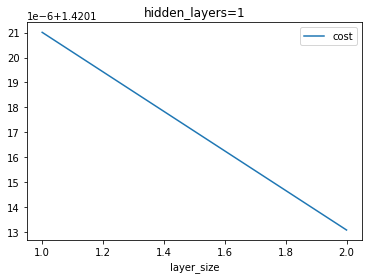

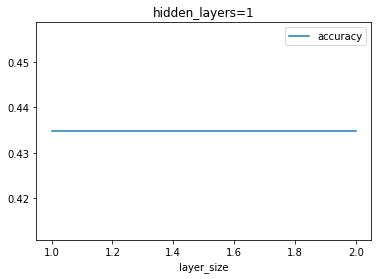

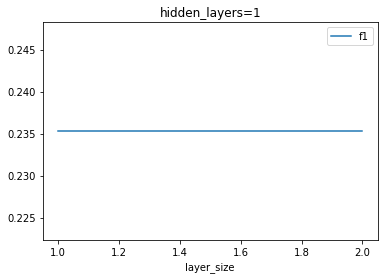

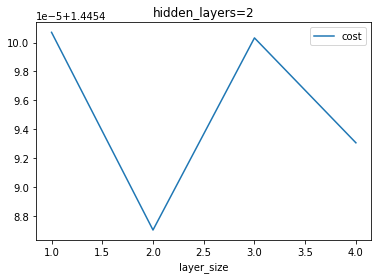

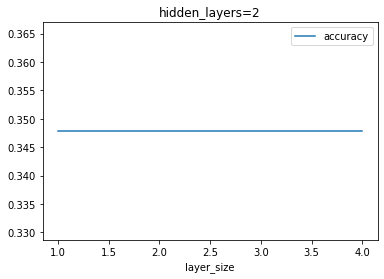

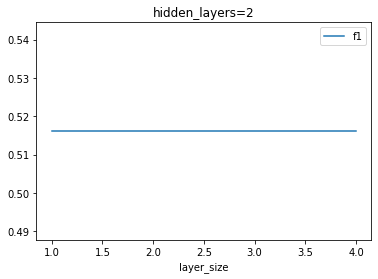

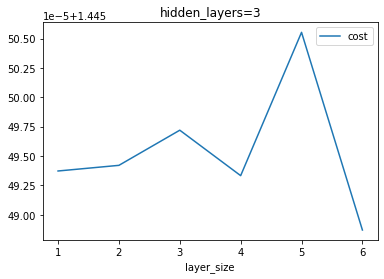

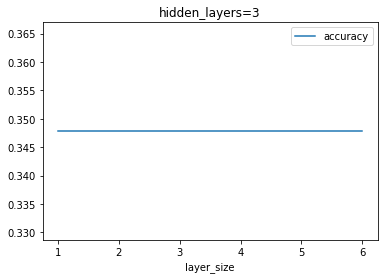

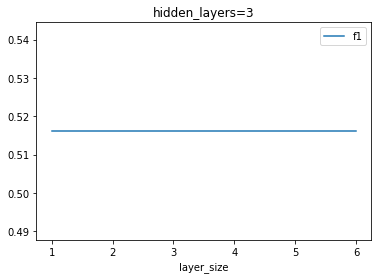

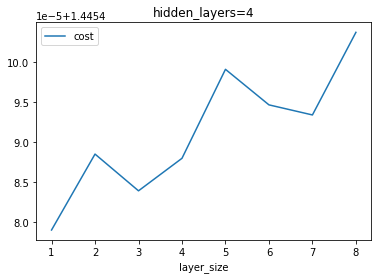

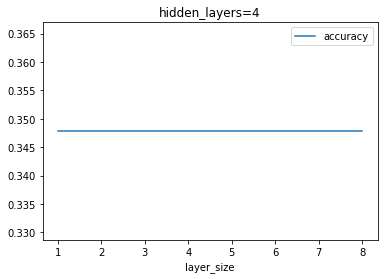

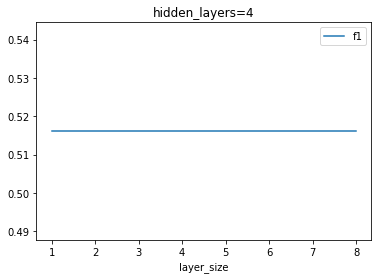

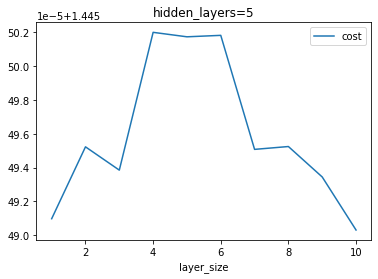

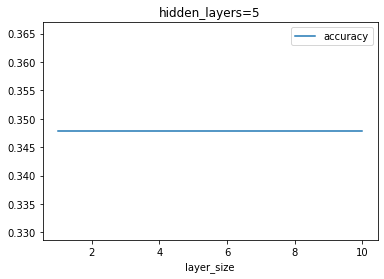

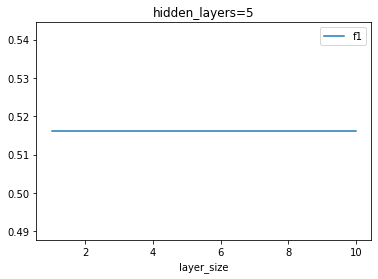

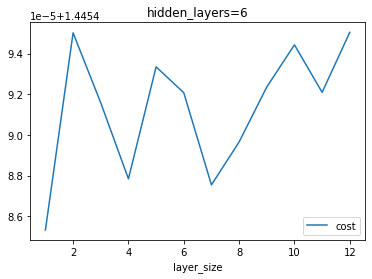

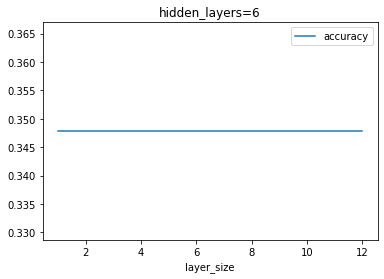

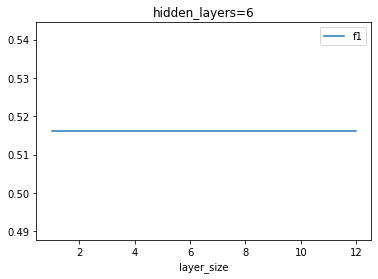

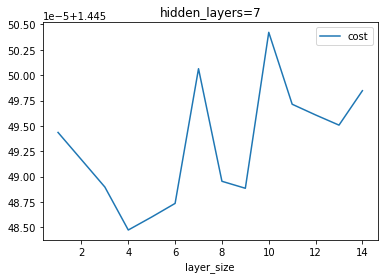

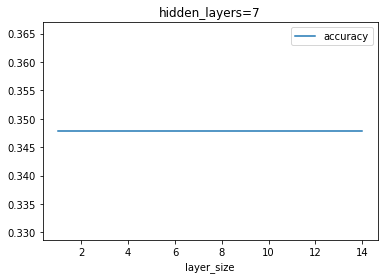

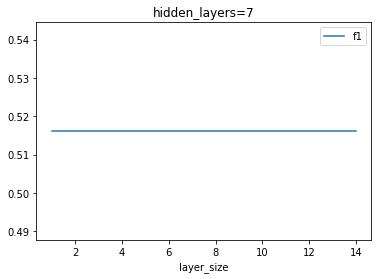

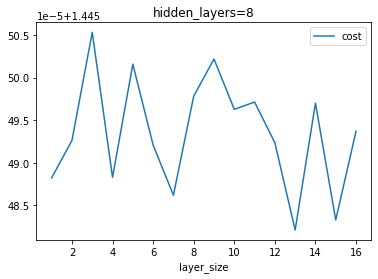

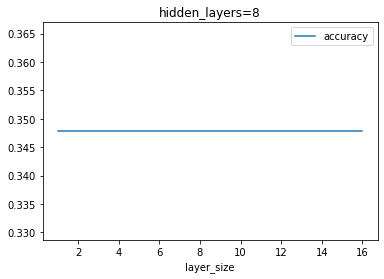

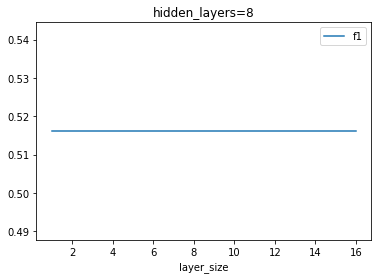

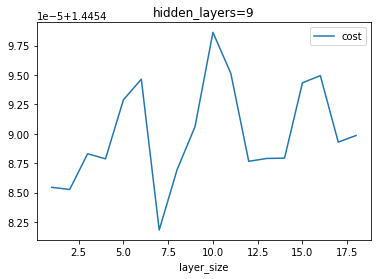

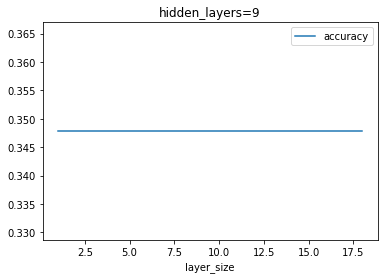

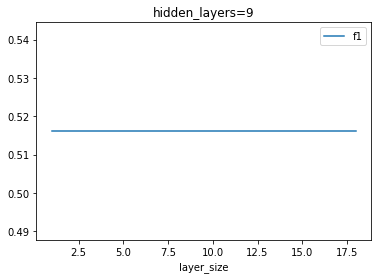

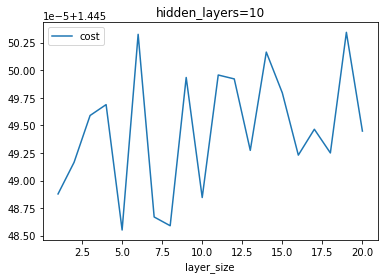

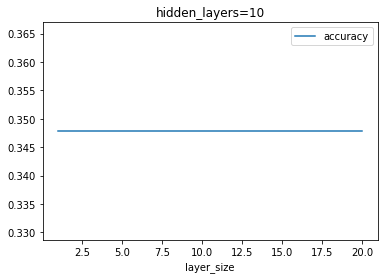

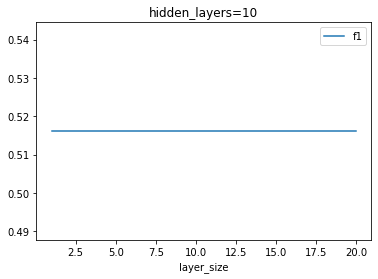

In [202]:
select_model(data, output_layer_size, 10)

In [203]:
hidden_layer_sizes = [2] * 1
X, y = extract(data, 0, data.shape[0] + 1)
Xtrain, ytrain = extract(data, 0, math.ceil(data.shape[0] * 0.8))
Xcv, ycv = extract(data, math.ceil(data.shape[0] * 0.8), data.shape[0] + 1)
theta = solve(X, y, 1, hidden_layer_sizes, output_layer_size)
print(data.columns)
theta

Index(['x1', 'x2', 'y', 'y^'], dtype='object')


array([[-2.40013889],
       [ 2.09454331],
       [ 1.37191932],
       [-2.63260787],
       [-1.78312712],
       [-1.65861707],
       [ 0.71657542],
       [-1.92318755],
       [-1.72683382],
       [-0.71669635],
       [ 1.92338678],
       [ 1.72716086]])

In [204]:
def plot_model(data, theta, hidden_layer_sizes, output_layer_size):
    X, y = extract(data, 0, data.shape[0] + 1)
    data['y^'] = predict(X, theta, hidden_layer_sizes, output_layer_size)
    
    ax = data[data['y'] == 0].plot.scatter(x='x1', y='x2', c='red')
    data[data['y'] == 1].plot.scatter(x='x1', y='x2', c='blue', ax=ax)
    data[data['y'] != data['y^']].plot.scatter(x='x1', y='x2', c='orange', ax=ax)

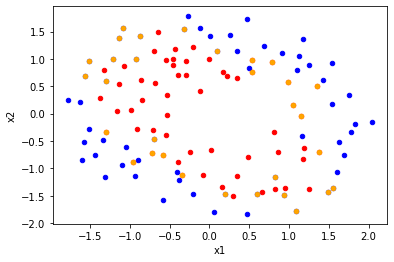

In [205]:
plot_model(data, theta, hidden_layer_sizes, output_layer_size)

In [206]:
def select_lambda(Xtrain, ytrain, Xcv, ycv, hidden_layer_sizes, output_layer_size, begin, end, step):
    m = data.shape[0]
    
    count = math.ceil((end - begin) / step)
    df = pd.DataFrame(index=range(0, count), columns=['lambda', 'cost', 'accuracy', 'f1'])
    
    for i in range(0, count):
        lamb = begin + i * step
        theta = solve(Xtrain, ytrain, lamb, hidden_layer_sizes, output_layer_size)
        cost = cost_fn(theta, Xcv, ycv, 0, hidden_layer_sizes, output_layer_size)
        acc = accuracy(Xcv, ycv, theta, hidden_layer_sizes, output_layer_size)
        f1 = f1score(Xcv, ycv, theta, hidden_layer_sizes, output_layer_size)
        df.loc[i] = [lamb, cost, acc, f1]
        
    df.plot.line(x='lambda', y='cost')
    df.plot.line(x='lambda', y='accuracy')
    df.plot.line(x='lambda', y='f1')
    df.sort_values(by=['cost'], inplace=True)
    print(df)

   lambda      cost  accuracy        f1
0       1  1.420126  0.434783  0.235294
12     13  1.445482  0.347826  0.516129
38     39  1.445488  0.347826  0.516129
3       4  1.445489  0.347826  0.516129
69     70  1.445489  0.347826  0.516129
..    ...       ...       ...       ...
15     16  1.445501  0.347826  0.516129
88     89  1.445501  0.347826  0.516129
6       7  1.445502  0.347826  0.516129
30     31  1.445504  0.347826  0.516129
13     14  1.445504  0.347826  0.516129

[99 rows x 4 columns]


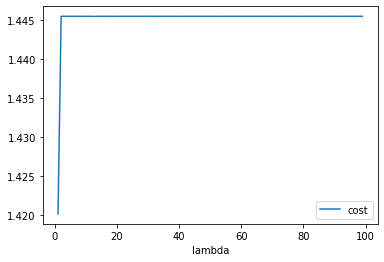

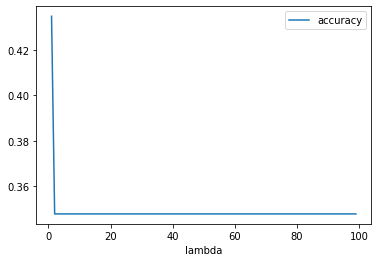

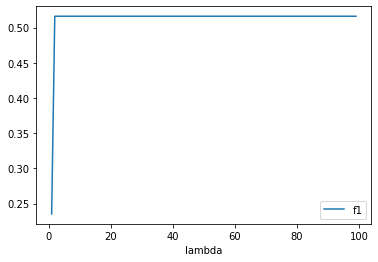

In [207]:
select_lambda(Xtrain, ytrain, Xcv, ycv, hidden_layer_sizes, output_layer_size, 1, 100, 1)

In [195]:
lamb = 0
theta = solve(X, y, lamb, hidden_layer_sizes, output_layer_size)
data['y^'] = predict(X, theta, hidden_layer_sizes, output_layer_size)
theta

<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))


array([[-27.47840603],
       [  9.56939439],
       [ 21.31885211],
       [ 54.97806496],
       [ 17.64650417],
       [ 38.61088825],
       [-52.62507339],
       [ 35.41633255],
       [  0.74341273],
       [ -4.1550284 ],
       [ 15.7959735 ],
       [ -7.22514801],
       [ 34.49584167],
       [-13.45902405],
       [  6.12588906],
       [-65.05442479],
       [  5.80013915],
       [-35.36492217],
       [  2.86514257],
       [ 44.7432928 ],
       [ 16.7437548 ],
       [-29.40692625],
       [-48.28091098],
       [-11.37133682],
       [ 30.23417806],
       [ 24.74656809],
       [ 40.57982816],
       [ 22.63240045],
       [-25.58683532]])

In [196]:
def draw_learning_curve(data, lamb, hidden_layer_sizes, output_layer_size, start=None, end=None):
    df = [] # m, cv, train
   
    start = start or 0
    end = end or data.shape[0]
    
    for m in range(start, end + 1):  
        Xtrain, ytrain = extract(data, 0, math.ceil(m*0.8))
        Xcv, ycv = extract(data, math.ceil(m*0.8), m + 1)
        if ycv.shape[0] < 1:
            continue
        
        theta = solve(Xtrain, ytrain, lamb, hidden_layer_sizes, output_layer_size)
        cost_train = cost_fn(theta, Xtrain, ytrain, 0, hidden_layer_sizes, output_layer_size)
        cost_cv = cost_fn(theta, Xcv, ycv, 0, hidden_layer_sizes, output_layer_size)
        
        df.append([m, cost_cv, cost_train])
            
    df = pd.DataFrame(df, columns=['m', 'cv', 'train'])
    ax = df.plot.line(x='m', y='cv')
    df.plot.line(x='m', y='train', ax=ax)


<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divid

<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divid

<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divid

<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divide by zero encountered in log
  J = J - (np.dot(yit, np.log(hi)) + np.dot(1 - yit, np.log(1 - hi)))
<ipython-input-186-294511641928>:60: RuntimeWarning: divid

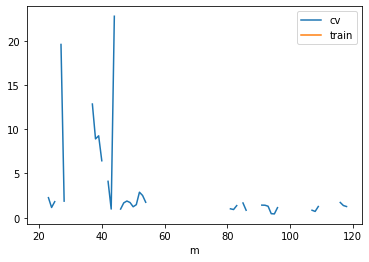

In [197]:
draw_learning_curve(data, lamb, hidden_layer_sizes, output_layer_size, start=20)